In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


In [39]:
# Model parameters
tau_m = 10.0      # membrane time constant (ms)
E_L = -65.0       # resting potential (mV)
R_m = 10.0        # membrane resistance (MΩ)
V_th = -50.0      # threshold potential (mV)
V_reset = -65.0   # reset potential (mV)
V_peak = 0.0      # spike peak (mV)


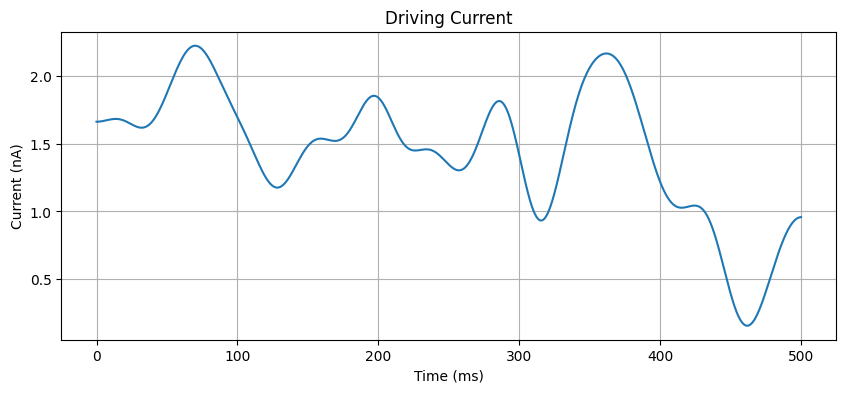

In [40]:
# Simulation parameters
dt = 0.1  # time step (ms)
T = 500   # total time (ms)
time = np.arange(0, T + dt, dt)

# Random driving current
np.random.seed()
raw_noise = np.random.randn(len(time))
I_e = 1.5 + gaussian_filter1d(raw_noise, sigma=150) * 12

# Plot driving current
plt.figure(figsize=(10, 4))
plt.plot(time, I_e)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.title('Driving Current')
plt.grid(True)
plt.show()


In [41]:
def dVdt(V, I):
    return (E_L - V + R_m * I) / tau_m


In [42]:
# Initialize membrane potential array
V = np.full_like(time, E_L)
V_plot = np.copy(V)


In [43]:
for i in range(1, len(time)):
    V0, I0 = V[i-1], I_e[i-1]
    k1 = dVdt(V0, I0) * dt
    k2 = dVdt(V0 + k1/2, I0) * dt
    k3 = dVdt(V0 + k2/2, I0) * dt
    k4 = dVdt(V0 + k3, I0) * dt
    V_temp = V0 + (k1 + 2*k2 + 2*k3 + k4) / 6

    if V_temp >= V_th:
        V_plot[i] = V_peak
        V[i] = V_reset
    else:
        V_plot[i] = V_temp
        V[i] = V_temp


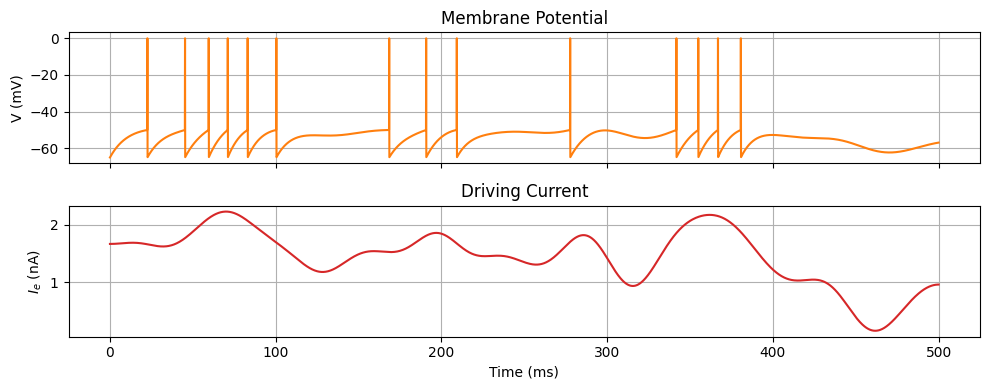

In [44]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 4))

axes[0].plot(time, V_plot, color='C1')
axes[0].set_title('Membrane Potential')
axes[0].set_ylabel('V (mV)')
axes[0].grid(True)

axes[1].plot(time, I_e, color='C3')
axes[1].set_title('Driving Current')
axes[1].set_ylabel('$I_e$ (nA)')
axes[1].set_xlabel('Time (ms)')
axes[1].grid(True)

plt.tight_layout()
plt.show()
